# Generative modeling in deep learning

*This notebook consists of common introductory questions, followed by 4 different generative models (GAN, VAE, Flow matching, Diffusion flow), and a common conclusive question. **Choose & implement 2 among the 4 models**, not all of them! If you train more models, write down below the 2 ones you want to be graded on. Do not forget the last common question.*

Generative modeling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modeling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modeling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

>**${\large\textbf{\green{Answer:}}}$ Some common metrics to compare two probability distributions include:**
>
>- **Total Variation (TV): Measures the $L_1$ distance between two distributions.**
>- **Kullback-Leibler (KL) Divergence: Measures how one probability distribution diverges from a second expected probability distribution. Used in Logistic Regression, Variational Autoencoders, t-SNE, etc. It is asymmetric and not a true distance metric.**
>- **Jensen-Shannon (JS) Divergence: A symmetric and smoothed version of KL divergence.**
>- **Wasserstein Distance (Optimal Transport Distance): Measures the minimum cost of transforming one distribution into another. Takes into account the geometry of the underlying space and is more robust to differences in support between distributions. Often computionally more expensive to calculate.**
>- **Maximum Mean Discrepancy (MMD): A kernel-based measure that compares the means of two distributions in a reproducing kernel Hilbert space. Often used to distinguish between two distributions based on samples only.**

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

>**${\large\textbf{\green{Answer:}}}$ For density-based methods, a key caveat is that they require the ability to compute or estimate the probability density functions of both distributions. This can be challenging for complex models or high-dimensional data. If the supports of the distributions do not overlap, density-based methods may yield saturated or infinite values, making optimization difficult. Additionally, density-based methods can be sensitive to outliers, which can disproportionately affect the estimated densities.** 
>
>**When it comes to sample-based methods, they often require a large number of samples to accurately estimate the distributions, which can be computationally expensive and hard to obtain. Sample-based methods may also be sensitive to the choice of kernel or distance metric used, which can impact the results and be sensitive to the curse of dimensionality when dealing with high-dimensional data. Additionally, sample-based methods may not capture all aspects of the distributions, especially if the samples are not representative of the entire distribution. Finally, the lack of an explicit density function can make it challenging to interpret the results and understand the underlying differences between the distributions.**

In this work, we will focus on the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GAN), Variational AutoEncoders (VAE), Flow Matching and Diffusion Models, in order to compare them and understand their strengths and weaknesses.

## Dataset

#### Checkerboard (prioritize this dataset)

In [1]:
import torch
import math
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt


def generate_batch(num_datapoints: int) -> np.ndarray:
    """Checkerboard dataset."""
    x1 = np.random.rand(num_datapoints) * 4 - 2
    x2 = (
        np.random.rand(num_datapoints)
        - np.random.randint(0, 2, [num_datapoints]) * 2.0
        + np.floor(x1) % 2
    )
    data = np.stack([x1, x2]).T * 2
    data = (data - data.mean(axis=0)) / data.std(axis=0)  # normalize
    return torch.from_numpy(data.astype(np.float32))


train_data = generate_batch(5000)

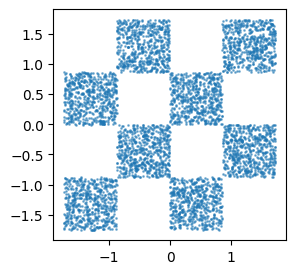

In [2]:
plt.figure(figsize=(3, 3))
plt.scatter(train_data.numpy()[:, 0], train_data.numpy()[:, 1], s=1.0, alpha=0.5)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular region of space. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

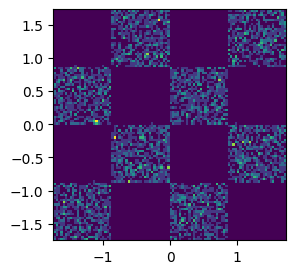

In [3]:
plt.figure(figsize=(3, 3))
plt.hist2d(train_data.numpy()[:, 0], train_data.numpy()[:, 1], bins=100)
plt.show()

#### Moon (use this one only if your models struggle on checkerboard)

In [14]:
# import torch
# import math
# from sklearn import datasets
# import numpy as np


# # Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# # an infinite-size dataset
# def generate_batch(batchlen):
#     """This function generates a batch of length 'batchlen' from the dataset"""
#     data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
#     return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

In [15]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# batch = generate_batch(5000)

# plt.scatter(batch[:, 0], batch[:, 1], s=2.0)
# plt.show()

It's also good to visualize the density as sometimes generative models overfit particular areas. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

In [16]:
# plt.hist2d(batch.numpy()[:, 0], batch.numpy()[:, 1], bins=100)
# plt.xlim([-1.2, 2.2])
# plt.ylim([-0.7, 1.2])
# plt.show()

----
## Generative Adversarial Networks

GANs structure is based on modeling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

>**${\large\textbf{\green{Answer:}}}$ The choice of N, the dimension of the input noise $\epsilon$, can significantly impact the performance and quality of the generated samples in a GAN. If N is too small, the model may not have enough capacity to capture the complexity of the target distribution, leading to mode collapse or poor diversity in the generated samples. Conversely, if N is too large, the optimization process may become more challenging, which can lead to overfitting or the ignoring of some dimensions of the noise vector. Ideally, N should be chosen to roughly match the intrinsic dimensionality of the input data, allowing the GAN to effectively learn its underlying structure while maintaining diversity in the generated samples.**

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

>**${\large\textbf{\green{Answer:}}}$ A caveat of using the JSD as a training objective for the generator is that it will fail when the supports of the two distributions do not overlap. In such cases, the JSD becomes constant and saturate to its maximum constant value. The JSD measures if the two distributions overlap, but not how far apart they are from each other. Therefore, the generator receives no feedback on how to improve in these situations.**

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

>**${\large\textbf{\green{Answer:}}}$ Only focusing the feedback on the generated samples only penalizes the generator on the samples it actually produces. It is not penalized for missing entire regions of the real data distribution. This can lead to mode collapse, where the generator produces a limited variety of samples, trading off diversity for quality.**

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2


# Define the generator
class Generator(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        return self.fc3(z)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.forward(z)


# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=512):  # Consider reducing hidden_dim for moon dataset
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(
            hidden_dim, hidden_dim
        )  # Overkill for moon dataset but better for checkerboard
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # Only keep if using checkerboard dataset
        return self.fc3(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.171e+00, generator: 8.863e-01


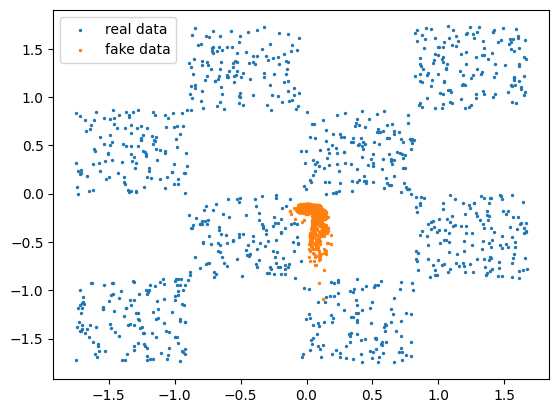

step 1000: discriminator: 1.359e+00, generator: 7.197e-01


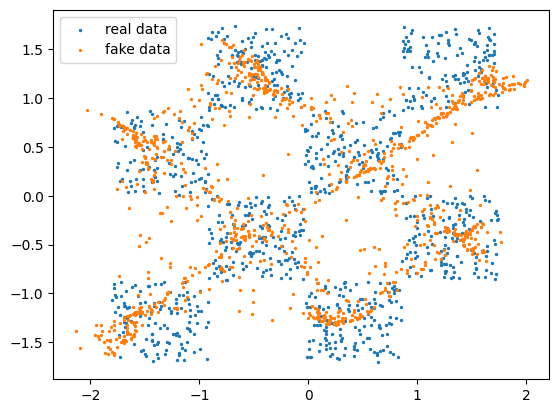

step 2000: discriminator: 1.382e+00, generator: 7.168e-01


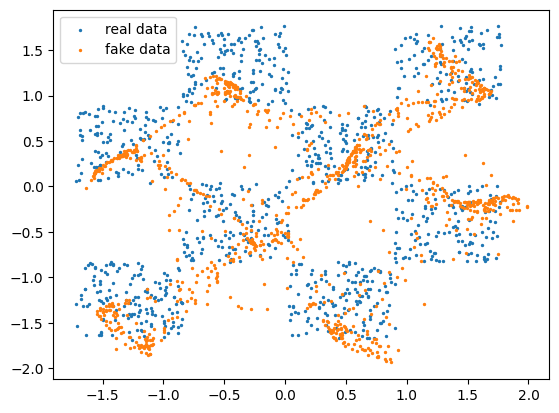

step 3000: discriminator: 1.396e+00, generator: 7.228e-01


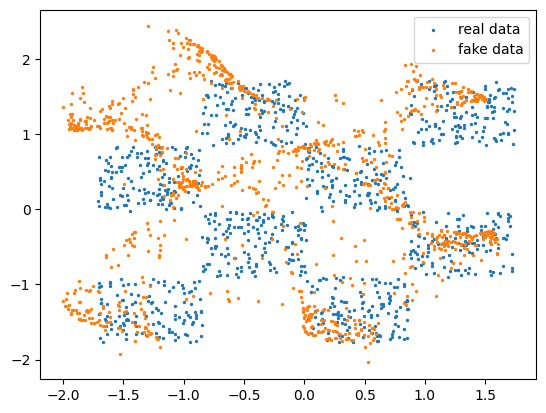

step 4000: discriminator: 1.360e+00, generator: 6.861e-01


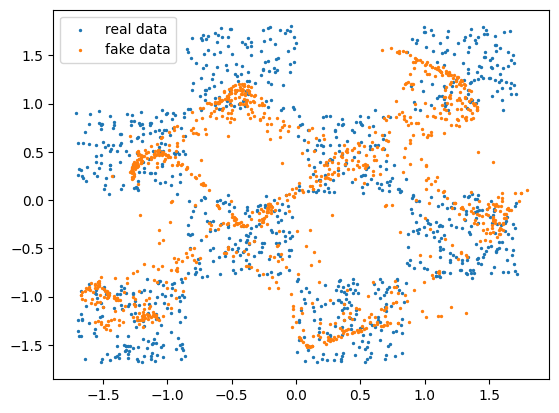

step 5000: discriminator: 1.388e+00, generator: 6.846e-01


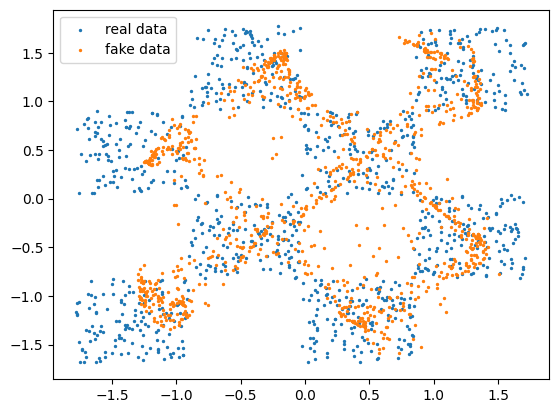

step 6000: discriminator: 1.385e+00, generator: 6.878e-01


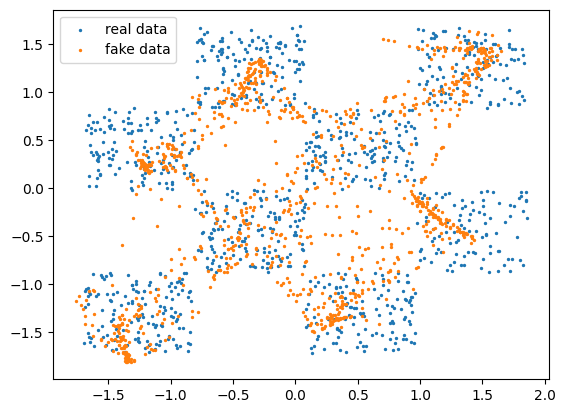

step 7000: discriminator: 1.380e+00, generator: 7.039e-01


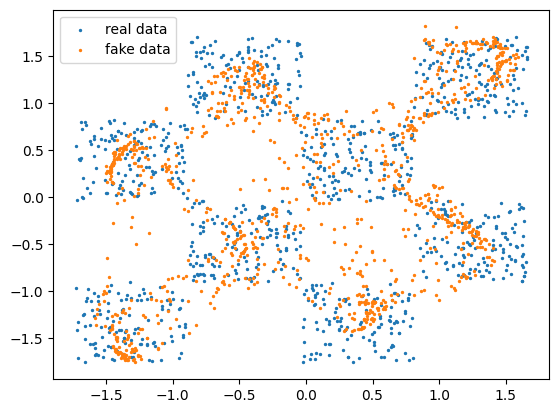

step 8000: discriminator: 1.391e+00, generator: 6.929e-01


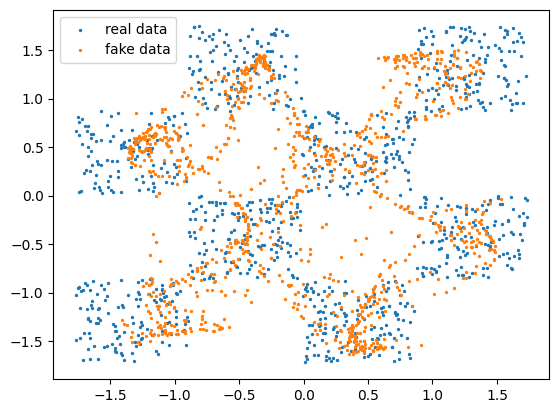

step 9000: discriminator: 1.402e+00, generator: 6.925e-01


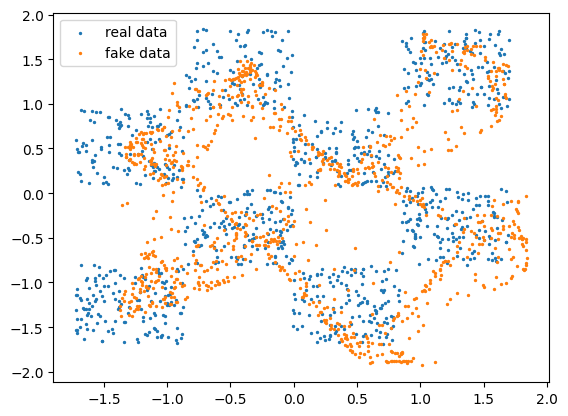

step 10000: discriminator: 1.379e+00, generator: 7.310e-01


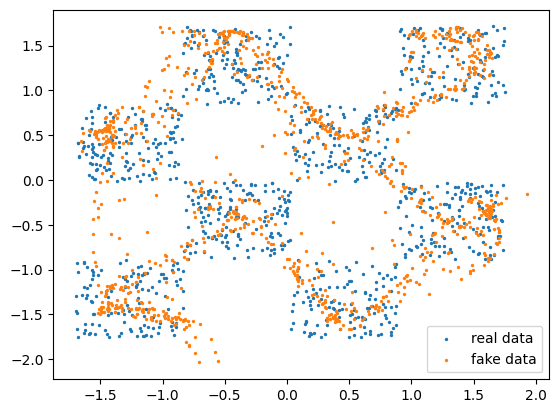

step 11000: discriminator: 1.375e+00, generator: 6.909e-01


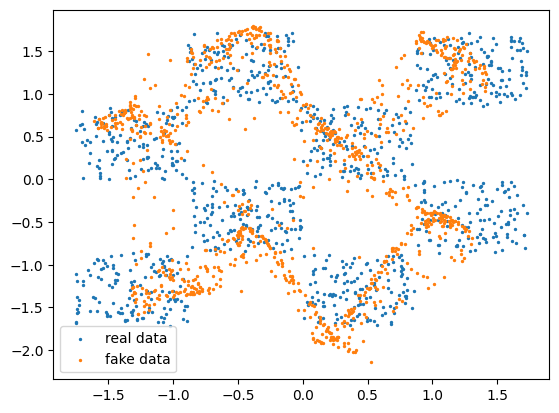

step 12000: discriminator: 1.377e+00, generator: 6.943e-01


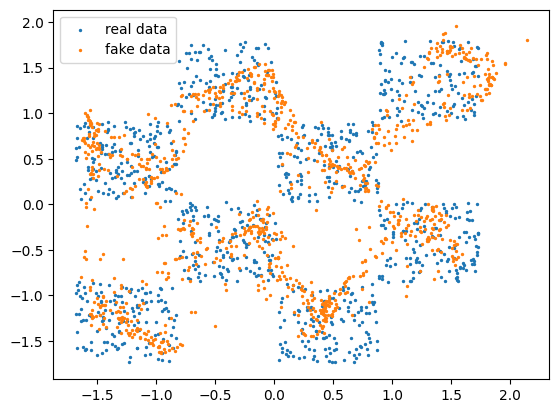

step 13000: discriminator: 1.379e+00, generator: 7.056e-01


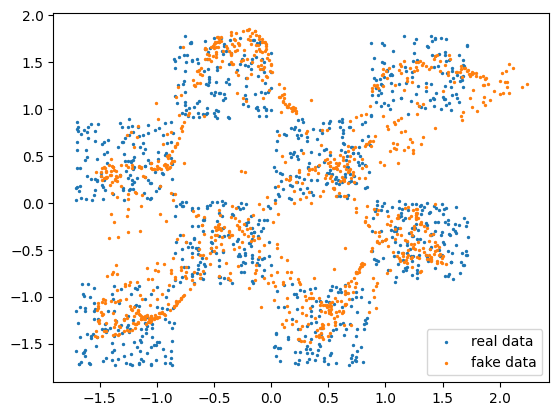

step 14000: discriminator: 1.396e+00, generator: 6.772e-01


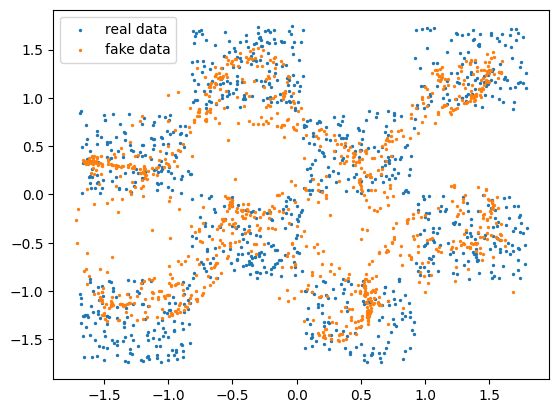

step 15000: discriminator: 1.390e+00, generator: 7.029e-01


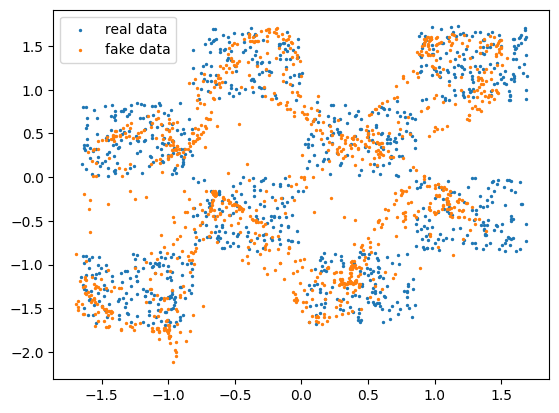

step 16000: discriminator: 1.392e+00, generator: 6.955e-01


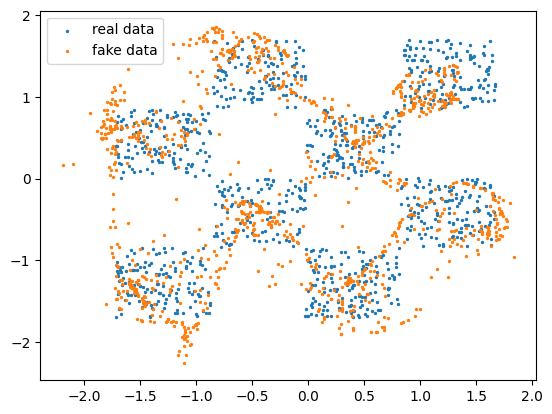

step 17000: discriminator: 1.383e+00, generator: 7.246e-01


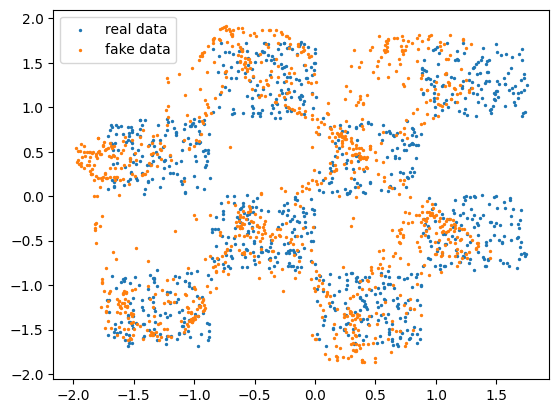

step 18000: discriminator: 1.377e+00, generator: 7.055e-01


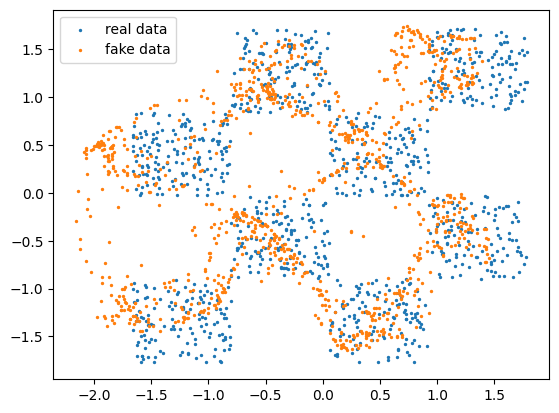

step 19000: discriminator: 1.387e+00, generator: 6.894e-01


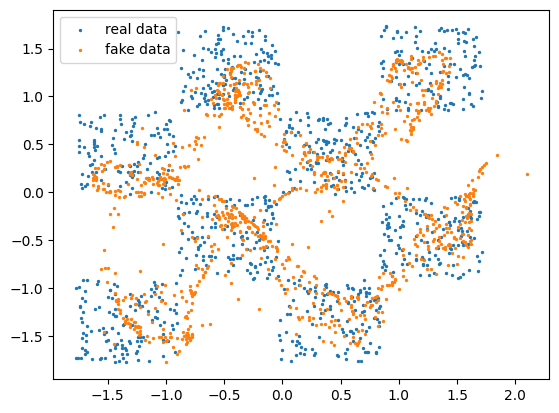

step 20000: discriminator: 1.382e+00, generator: 6.870e-01


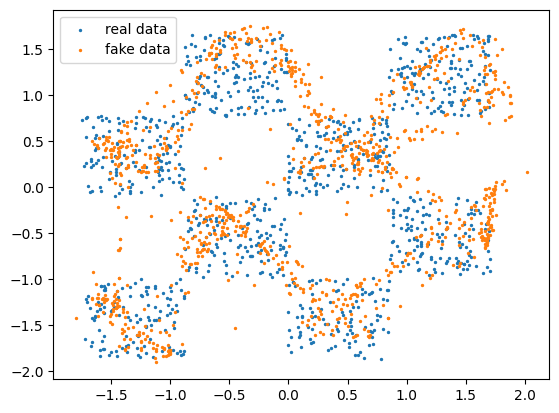

In [47]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 2  # Consider 3 for checkerboard dataset
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.9))

criterion = nn.BCEWithLogitsLoss()

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        #
        real_pred = discriminator(real_batch)
        real_loss = criterion(real_pred, torch.ones_like(real_pred))
        fake_pred = discriminator(fake_batch.detach())
        fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))

        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #
    fake_pred = discriminator(fake_batch)
    gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))
    gen_loss.backward()
    optim_gen.step()
    if i % 1000 == 0:
        print(
            "step {}: discriminator: {:.3e}, generator: {:.3e}".format(
                i, float(disc_loss), float(gen_loss)
            )
        )
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:, 0], real_batch[:, 1], s=2.0, label="real data")
        plt.scatter(fake_batch[:, 0], fake_batch[:, 1], s=2.0, label="fake data")
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

>**${\large\textbf{\green{Answer:}}}$ The primary cause of collapse is the vanishing gradient problem. When the discriminator becomes too good at distinguishing real from fake samples, the output of the discriminator for generated samples approaches zero. As a result, the term $\log(1-D(x))$ in the generator's loss becomes very small, leading to very small gradients during training. The generator thus receives little to no feedback on how to improve its samples because the signal it gets from the discriminator is too weak to tell it how to adjust its parameters effectively.**

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

>**${\large\textbf{\green{Answer:}}}$ The depth of the generator network determines the ability of the generator to learn complex mappings from the noise distribution to the data distribution. If too shallow, the generator may lack the capacity to model intricate patterns in the data and if too deep, it may be harder to optimize, overfit, or demonstrate mode collapse as we discussed in the previous questions.**
>
>**The depth of the discriminator network affects its ability to distinguish between real and fake samples. A shallow discriminator could struggle to distinguish between the two distributions, while a very deep discriminator could overfit to the training data, leading to poor generalization and vanishing gradients for the generator as we also discussed previously.**
>
>**The variable `TRAIN_RATIO` controls the number of times the discriminator is trained for each generator update. A higher value allows the discriminator to learn more effectively, providing stronger feedback to the generator. However, if this ratio is too high, the discriminator may become too powerful, leading to vanishing gradients for the generator. Conversely, a low `TRAIN_RATIO` may result in an undertrained discriminator, providing weak feedback to the generator and thus keeping it from learning effectively.**

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

---
## Denoising Diffusion Model

Recently Diffusion Models received a lot of attention. __Diffusion Models Beat GANs on Image Synthesis__ *(Dhariwal,Nichol)* : [arXiv:2105.05233](https://arxiv.org/pdf/2105.05233.pdf) shows significant improvement on image generation with a model claimed to be easier to train than GANs.


It is the key of the image generating process behind Latent Diffusion models such as Dall.e, Imagen or StableDiffusion. 

We are going to implement a model inspired by the paper
__Denoising Diffusion Probabilistic Models__  *(Ho et al.)*: [arXiv:2006.11239](https://arxiv.org/pdf/2006.11239.pdf) 


 Denoising diffusion probabilistic model  introduce noise into data and gradually learn to reverse this process for generating new samples. It involves two Markov chains, one that forwards data to noise, and another that reverses this process by converting the noise back to data. The forward chain is usually designed to transform any data distribution into a simpler prior distribution, such as a standard Gaussian distribution, while the reverse Markov chain is parametrized by a neural network and learns to reverse this process. To generate new data points, we first sample a random vector from the prior distribution, then applies ancestral sampling through the reverse Markov chain.

 References:

- Survey on Diffusion Models : https://arxiv.org/pdf/2209.00796.pdf
- https://lilianweng.github.io/posts/2021-07-11-diffusion-models/
- https://blog.alexalemi.com/diffusion.html
- https://sander.ai/posts/



![Denoisingdiagram](./illustrationDenoising.png)

$q$ and $p_{\theta}$ being the respective kernels of the two chains. 


#### Forward Pass ####

For our purpose we are going to use a Gaussian Noise. The forward Kernel will have the following shape : 

$$q(x_t| x_{t-1}) = \mathcal{N}(x_t;\sqrt{1- \beta_t} x_{t-1},\beta_t I )$$

with $\mathcal{N}(x;\mu,\sigma I )$ a conditional gaussian :
$$ y \sim \mathcal{N}(x;\mu,\sigma I ) \equiv y|x \sim  \mathcal{N}(\mu,\sigma I )$$

**Q20: What does $\beta_t$ represent in the formula ?**

>**${\large\textbf{\green{Answer:}}}$ In the formula, $\beta_t$ represents the variance of the Gaussian noise at time step t. It controls the amount of noise added to the data point at $x_{t-1}$ to produce the data point at time step $x_t$. It also determines how much of the original data point $x_{t-1}$ is retained in the new data point $x_t$ with the term $\sqrt{1- \beta_t} x_{t-1}$ used as the mean of the Gaussian distribution.**

In our example the sequence $\beta_t$ will be chosen linearly wrt $t$. 

We introduce $\alpha_t := 1-\beta_t$ and $\overline{\alpha_t} = \prod_{s=1}^{t} \alpha_s$ we can sample forward directly at timestep $t$ from the original image : 
$$q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t=1}^{T}q(\mathbf{x}_t|\mathbf{x}_{t-1})$$
$$ q(\mathbf{x}_t| \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t;\sqrt{\overline{\alpha_t}} \mathbf{x}_0, (1-\overline{\alpha_t})I)$$

i.e. 
\begin{align}
\boldsymbol{x}_t = \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon} \;\;\; \text{where} \; \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
\end{align}

we will then fix $$\sigma_t = \sqrt{1 - \bar{\alpha}_t}$$

**Q22:  Implement the forward pass using $\overline{\alpha_t}$ (Hint : you may need to precalculate the $\overline{\alpha_t}$ from $\beta_t$)**

In [4]:
def bcast_right(x: torch.Tensor, ndim: int) -> torch.Tensor:
    """Util function for broadcasting to the right."""
    if x.ndim > ndim:
        raise ValueError(f"Cannot broadcast a value with {x.ndim} dims to {ndim} dims.")
    elif x.ndim < ndim:
        difference = ndim - x.ndim
        return x.view(x.shape + (1,) * difference)
    else:
        return x


In [5]:
class DiscreteDDPMProcess:
    """A Gaussian diffusion process: q(xt|x0) = N(sqrt_alpha_bar(t)*x0, sigma(t)^2 * I),
    which implies the following transition from x0 to xt:

    xt = sqrt_alpha_bar(t) x0 + sigma(t) eps, eps ~ N(0, I).

    Diffusion processes differ in how they specify sqrt_alpha_bar(t) and/or sigma(t).
    Here we follow the DDPM paper.

    """

    def __init__(
        self,
        num_diffusion_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
    ):
        self._num_diffusion_timesteps = num_diffusion_timesteps
        self._beta_start = beta_start
        self._beta_end = beta_end
        self._betas = np.linspace(
            self._beta_start, self._beta_end, self._num_diffusion_timesteps
        )

        alphas_bar = self._get_alphas_bar()
        ###############
        # TO COMPLETE #
        ###############
        self._sqrt_alphas_bar = torch.from_numpy(np.sqrt(alphas_bar)).type(
            torch.float32
        )  # put in dtype=torch.float32
        self._sigmas = torch.from_numpy(np.sqrt(1 - alphas_bar)).type(
            torch.float32
        )  # put in dtype=torch.float32

    @property
    def tmin(self):
        return 1

    @property
    def tmax(self):
        return self._num_diffusion_timesteps

    def _get_alphas_bar(self) -> np.ndarray:
        ###############
        # TO COMPLETE #
        ###############
        alphas_bar = np.cumprod(1 - self._betas)

        # we can add this 1 in front to simplify indexing,
        # and to make alpha[0]=1 and sigma[0]=0.
        # these values at t=0 will be needed later when generating samples
        alphas_bar = np.concatenate(([1.0], alphas_bar))

        return alphas_bar

    def sqrt_alpha_bar(self, t: torch.Tensor) -> torch.Tensor:
        return self._sqrt_alphas_bar[t.long()]

    def sigma(self, t: torch.Tensor) -> torch.Tensor:
        return self._sigmas[t.long()]

    def sample(
        self, x0: torch.Tensor, t: torch.Tensor, eps: torch.Tensor
    ) -> torch.Tensor:
        """Draws samples from the forward diffusion process q(xt|x0)."""
        ###############
        # TO COMPLETE #
        ###############
        sqrt_alpha_bar_t = bcast_right(self.sqrt_alpha_bar(t), x0.ndim)
        sigma_t = bcast_right(self.sigma(t), x0.ndim)

        return sqrt_alpha_bar_t * x0 + sigma_t * eps

In [6]:
# data loading
test_data = generate_batch(1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
ts = torch.Tensor(
    np.linspace(process.tmin, process.tmax, num=process.tmax, dtype=np.int32)
)

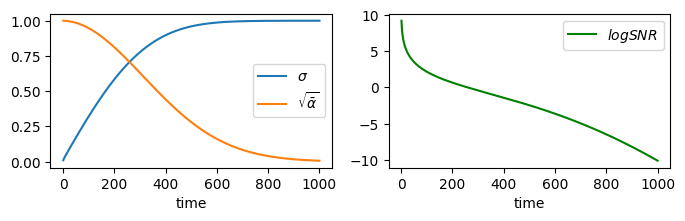

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(4 * 2, 2))

# plot how sqrt_alpha_bar and sigma change over time
ax[0].plot(ts.numpy(), process.sigma(ts), label=r"$\sigma$")
ax[0].plot(ts.numpy(), process.sqrt_alpha_bar(ts), label=r"$\sqrt{\bar\alpha}$")
ax[0].set_xlabel("time")
ax[0].legend()

# It is often helpful to reason in terms of signal-to-noise ratio:
# SNR = sqrt_alpha_bar(t)^2 / sigma(t)^2 or more conveniently, its logarithm.
# High SNR = little noise, low SNR = a lot of noise.
lambda_ = [2.0 * np.log(process.sqrt_alpha_bar(t) / process.sigma(t)) for t in ts]
ax[1].plot(ts.numpy(), lambda_, c="g", label=r"$log SNR$")
ax[1].set_xlabel("time")
ax[1].legend()

plt.show()

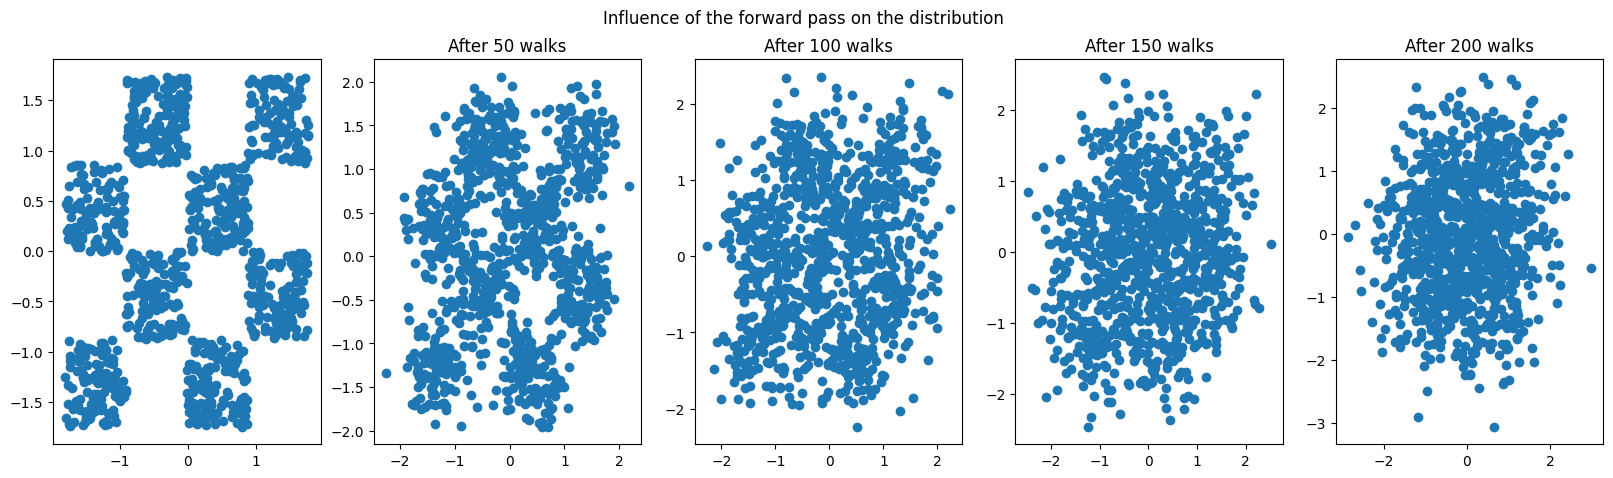

In [9]:
# Effect on the distribution
torch_test_data = torch.Tensor(test_data)


def apply_on_dataset(dataset, t):
    dataset_t = torch.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        point = dataset[i]
        eps = torch.randn_like(point)
        point_t = process.sample(point, t, eps)
        dataset_t[i] = point_t
    return dataset_t


fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].scatter(torch_test_data[:, 0], torch_test_data[:, 1])
for i in range(1, 5):
    t = torch.Tensor([i * 50]).type(torch.int64)
    dataset_t = apply_on_dataset(torch_test_data, t)
    axes[i].scatter(dataset_t[:, 0], dataset_t[:, 1])
    axes[i].set_title(f"After {t.detach().item()} walks")
fig.suptitle("Influence of the forward pass on the distribution")
plt.show()


#### Backward Process

Hypothetically, We would like  to train the reverse kernel $p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$, with parameters $\theta$ parametrized by a neural network 

$$
p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)
$$

with $p(\mathbf{x}_T)$ a Gaussian prior, $p(\mathbf{x}_T) \sim \mathcal{N}(0,I)$ . We would use $p(\mathbf{x}_T)$ to sample new data points for generation.

#### Variational Lower Bound 

In the paper, they used the knowledge of the forward pass and design a  Gaussian  reverse kernel

$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$

with $\mu_{\theta}$ and $\Sigma_{\theta}$  parametrized by a neural network

We can write the previous forward kernel
$$
\begin{aligned}
q\left(\mathbf{x}_t \mid \mathbf{x}_0\right) & =\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right) \\
& =\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\epsilon \sqrt{1-\bar{\alpha}_t}
\end{aligned}
$$
with $ \epsilon \sim \mathcal{N}(0, \mathbf{I})$ 

The natural loss would be to optimize under the variational lower bound $L_t$ such that : 
$$
\begin{aligned}
L_{\mathrm{vlb}} & :=L_0+L_1+\ldots+L_{T-1}+L_T \\
L_0 & :=-\log p_\theta\left(x_0 \mid x_1\right) \\
L_{t-1} & :=D_{K L}\left(q\left(x_{t-1} \mid x_t, x_0\right) \| p_\theta\left(x_{t-1} \mid x_t\right)\right) \\
L_T & :=D_{K L}\left(q\left(x_T \mid x_0\right) \| p\left(x_T\right)\right)
\end{aligned}
$$

One can show that an alternative loss can be used that only take one parametrized estimator $\epsilon_{\theta}$. \
Hint: KL divergences between Gaussian distributions can be computed analytically
$$
L_{\text {simple }}(\theta):=\mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}}\left[\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2\right]
$$

Let's start implementing the network that predicts $\widehat \epsilon(x_t, t; \theta)$. Note that, as stated by its definition, $\epsilon$ is the cumulated noise from $t=0$ and not just the noise added at the last step.

In [10]:
import torch.nn as nn


class ResidualMLP(nn.Module):
    """MLP with residual connections."""

    def __init__(
        self,
        n_blocks: int,
        n_hidden: int,
        n_out: int,
        activation: str,
        name: str = None,
    ):
        super(ResidualMLP, self).__init__()
        self._n_blocks = n_blocks
        self._n_hidden = n_hidden
        self._n_out = n_out
        self._activation = getattr(nn.functional, activation)

        self.linear_input = nn.Linear(n_out, n_hidden)
        self.linear_time = nn.ModuleList(
            [nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)]
        )
        self.linear_hidden = nn.Sequential(
            nn.ModuleList(
                [nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)]
            ),
            nn.ModuleList(
                [nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)]
            ),
        )
        self.linear_output = nn.Linear(n_hidden, n_out)

    def forward(self, xt: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(xt)

        for _ in range(self._n_blocks):
            h = self._activation(x)
            h = self.linear_hidden[_][0](h)
            h = h + self.linear_time[_](time)
            h = self._activation(h)
            h = self.linear_hidden[_][1](h)
            x = x + h

        outputs = self.linear_output(x)

        return outputs


#### Time embeddings

As we can see above, the denoiser network needs to get timestep $t$ as an input.

However, feeding integers $t=1, 2, ... T$ into the network will not work.

[Transformers](https://arxiv.org/abs/1706.03762), when faced with the same problem, proposed to embed timesteps into $d$-dimensional vectors of sinusoids:

$$e = [\; \sin(w_1 t) \; \; \cos(w_1 t) \; ... \; \sin(w_{d/2} t) \; \; \cos(w_{d/2} t) \;]$$

with $w_i = 1/ 10000^{\frac{2i}{d}}$.

Here is nice blogpost with more intuition: https://kazemnejad.com/blog/transformer_architecture_positional_encoding/


In [11]:
class SinusoidalTimeEmbedding(nn.Module):
    """Time (positional) embedding as in Transformers."""

    def __init__(self, num_features: int, name: str = None):
        super(SinusoidalTimeEmbedding, self).__init__()
        self._num_features = num_features

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        assert len(inputs.shape) == 1
        half_dim = self._num_features // 2
        e = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        embedding = torch.exp(-e * torch.arange(half_dim).float()).to(device)
        embedding = inputs.view(-1, 1) * embedding
        embedding = torch.cat([torch.cos(embedding), torch.sin(embedding)], dim=-1)
        if self._num_features % 2 == 1:
            embedding = nn.functional.pad(embedding, (0, 1))
        return embedding


Now we need to put the two modules together:

In [12]:
import dataclasses


@dataclasses.dataclass
class NetConfig:
    resnet_n_blocks: int = 2
    resnet_n_hidden: int = 256
    resnet_n_out: int = 2
    activation: str = "elu"
    time_embedding_dim: int = 256


class Net(nn.Module):
    """Combines MLP and time embeddings."""

    def __init__(self, net_config: NetConfig, name: str = None):
        super(Net, self).__init__()

        self._time_encoder = SinusoidalTimeEmbedding(net_config.time_embedding_dim)
        self._predictor = ResidualMLP(
            n_blocks=net_config.resnet_n_blocks,
            n_hidden=net_config.resnet_n_hidden,
            n_out=net_config.resnet_n_out,
            activation=net_config.activation,
        )

    def forward(self, noisy_data: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        time_embedding = self._time_encoder(time)
        outputs = self._predictor(noisy_data, time_embedding)
        return outputs


#### Time sampler

To compute our loss function, for each example, we need to sample a random timestep. In this trivial case of uniform sampling between step 1 and T, it might be an overkill to implement it as a separate class. It would be more helpful if you're going to explore more exotic diffusion models.

In [13]:
from typing import Sequence


class UniformDiscreteTimeSampler:
    def __init__(self, tmin: int, tmax: int):
        self._tmin = tmin
        self._tmax = tmax

    def sample(self, shape: Sequence[int]) -> torch.Tensor:
        return torch.randint(low=self._tmin, high=self._tmax, size=shape)


#### Full DDPM model

**Q.23 Implement the Simplified loss given a model $\epsilon_{\theta}$**

In [14]:
from typing import Tuple


class DiffusionModel(nn.Module):
    """Diffusion model."""

    def __init__(self, diffusion_process, time_sampler, net_config, data_shape):
        super(DiffusionModel, self).__init__()

        self._process = diffusion_process
        self._time_sampler = time_sampler
        self._net_config = net_config
        self._data_shape = data_shape
        self.net_fwd = Net(net_config)

    def loss(self, x0: torch.Tensor) -> torch.Tensor:
        """Computes MSE between the true noise and predicted noise,
        i.e. the goal of the network is to correctly predict eps from a noisy observation
        xt = alpha(t) * x0 + sigma(t)**2 * eps"""

        ###############
        # TO COMPLETE #
        ###############

        t = self._time_sampler.sample((x0.shape[0],))  # sample time

        eps = torch.randn_like(x0)  # sample noise

        xt = self._process.sample(x0, t, eps)  # corrupt the data

        net_outputs = self.net_fwd(xt, t)  # get net outputs

        criterion = nn.MSELoss()
        loss = criterion(
            net_outputs, eps
        )  # compute MSE loss between predicted and true noise

        return loss

    # Used for sampling
    def _reverse_process_step(
        self,
        xt: torch.Tensor,
        t: int,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Computes parameters of a Gaussian p_{\theta}(x_{t-1}| x_t)."""

        t = t * torch.ones((xt.shape[0],), dtype=torch.int32, device=xt.device)

        ###############
        # TO COMPLETE #
        ###############

        eps_pred = self.net_fwd(xt, t)  # predict epsilon from x_t

        sqrt_alpha_t = self._process.sqrt_alpha_bar(t) / self._process.sqrt_alpha_bar(
            t - 1
        )  # use self._sqrt_alpha_bar
        inv_sqrt_alpha_t = bcast_right(1.0 / sqrt_alpha_t, xt.ndim)

        beta_t = torch.from_numpy(self._process._betas).to(
            device=xt.device, dtype=xt.dtype
        )[t.long() - 1]
        beta_t = bcast_right(beta_t, xt.ndim)

        inv_sigma_t = 1.0 / self._process.sigma(t)
        inv_sigma_t = bcast_right(inv_sigma_t, xt.ndim)

        mean = inv_sqrt_alpha_t * (xt - beta_t * inv_sigma_t * eps_pred)

        # DDPM instructs to use either the variance of the forward process
        # or the variance of q(x_{t-1}|x_t, x_0). Former is easier.
        std = torch.sqrt(beta_t)  # because beta = 1 - alpha

        eps = torch.randn_like(xt) if t.min() > 1 else torch.zeros_like(xt)

        return mean, std * eps

    def sample(self, x0, sample_size):
        """To generate samples from DDPM, we follow the reverse process.
        At each step of the chain, we sample x_{t-1} from p(x_{t-1}| x_t, x0_pred) until we get to x_0."""
        with torch.no_grad():
            x = torch.randn(
                (sample_size,) + self._data_shape, device=x0.device
            )  # sample pure noise

            ###############
            # TO COMPLETE #
            ###############
            for t in reversed(range(self._process.tmin, self._process.tmax + 1)):
                mean, stdeps = self._reverse_process_step(x, t)
                x = mean + stdeps

        return x

Given the noise obtained by the model $\boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)$, you can sample $\mu_{\theta}(\mathbf{x}_t,t)$ in order to get a denoised sample point.
$$
\mu_{\theta}(\mathbf{x}_t,t) = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)
$$ 


The _reverse_process_step function sample $x_{t-1} \sim p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$ where
$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$
and we set $$\Sigma_\theta\left(\mathbf{x}_t, t\right) = \beta_{t}\boldsymbol{I}$$

Thus $$x_{t-1} = \mu_{\theta}(\mathbf{x}_t,t) + \sqrt{\beta_t}\epsilon$$ where $$\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$$

**Q.24 Build the sampling function that allows you from inputs $\mathbf{x}_t$ and $t$ to obtain $\mu_{\theta}(\mathbf{x}_t,t)$ and $x_{t-1}$**

#### Training

In [15]:
from torch import optim

# create the model
diffusion_process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
time_sampler = UniformDiscreteTimeSampler(
    diffusion_process.tmin, diffusion_process.tmax
)
model = DiffusionModel(
    diffusion_process, time_sampler, net_config=NetConfig(), data_shape=(2,)
).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

We will use a learning rate scheduler with a warmup. \
You will have to install the library pytorch_warmup with "pip install -U pytorch_warmup": https://github.com/Tony-Y/pytorch_warmup \
Our learning rate schedule will have the following shape.

![Denoisingdiagram](./lr_with_warmup.png)

In [16]:
import pytorch_warmup as warmup

training_steps = 50000

warmup_period = 1000  # this is the increasing part of the learning rate schedule
num_steps = training_steps
t0 = num_steps // 1
lr_min = 3e-12
max_step = (
    t0 * 1 + warmup_period
)  # you can also create cycle but we won't touch it here

lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=t0, T_mult=1, eta_min=lr_min
)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


##### Training loop

**Q.25 Train $\epsilon_{\theta}(\mathbf{x},t)$ that take as entry a transformed vector $\mathbf{x}$ and  $t$ a number of time $\mathbf{x}$ passed through the forward process  and return  a direct estimate of  the noise $\epsilon$**

Step: 0, Loss: 1.44941


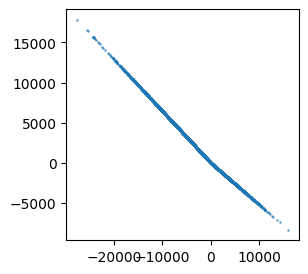

Step: 5000, Loss: 0.24534
Step: 10000, Loss: 0.24878


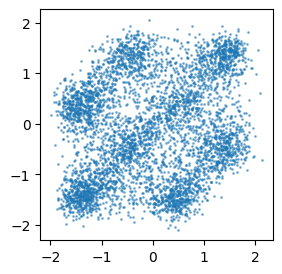

Step: 15000, Loss: 0.21657
Step: 20000, Loss: 0.27538


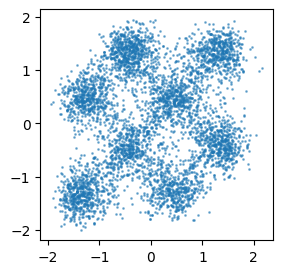

Step: 25000, Loss: 0.24872
Step: 30000, Loss: 0.26558


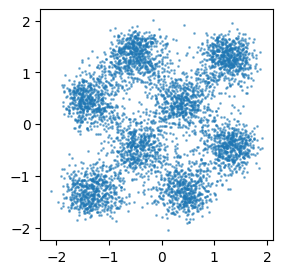

Step: 35000, Loss: 0.29048
Step: 40000, Loss: 0.25577


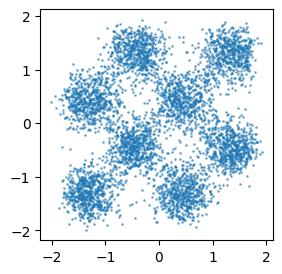

Step: 45000, Loss: 0.28317


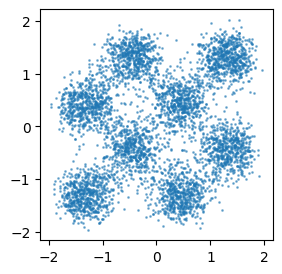

In [17]:
BATCH_SIZE = 1024


for step in range(training_steps):
    # generate batch on the fly

    ###############
    # TO COMPLETE #
    ###############
    optimizer.zero_grad()
    x0 = generate_batch(BATCH_SIZE).to(device)

    loss = model.loss(x0)
    loss.backward()
    optimizer.step()

    if step % 5000 == 0:
        print(f"Step: {step}, Loss: {loss:.5f}")

    if step % 10000 == 0 or step == training_steps - 1:
        with torch.no_grad():
            samples = model.sample(x0=x0, sample_size=5000)  # create new samples
        plt.figure(figsize=(3, 3))
        plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
        plt.show()

    with warmup_scheduler.dampening():
        if warmup_scheduler.last_step + 1 >= warmup_period:
            lr_scheduler.step()
        if warmup_scheduler.last_step + 1 >= max_step:
            break

#### Ablation study

**Q.26 Perform ablations experiments on hyperparameters, such as: learning rate (try constant learning rate with different values), batch size, the number of timesteps, the positional embedding for timestep (remove it), the hidden size, number of epochs, skip connections**

For a given ablation experiment (they ought to be done separately!), you should plot generated samples at few given timesteps (if compute resources is limited, do it for one timestep).

Note: you don't have to do all of these experiments, but the bigger is your group, the more you should do.

In [25]:
import copy
from torch import optim
import pytorch_warmup as warmup

In [33]:
baseline_config = {
    "num_diffusion_timesteps": 1000,
    "lr": 3e-4,
    "training_steps": 50000,
    "warmup_period": 1000,
    "lr_min": 3e-12,
    "BATCH_SIZE": 1024,
    "use_scheduler": True,
    "net_config": {
        "resnet_n_blocks": 2,
        "resnet_n_hidden": 256,
        "resnet_n_out": 2,
        "activation": "elu",
        "time_embedding_dim": 256,
    },
}


@torch.no_grad()
def sample_with_snapshots(model, sample_size, timesteps_to_save):
    """
    Runs the reverse diffusion process and saves samples at specified timesteps.
    """
    device = next(model.parameters()).device
    x = torch.randn((sample_size,) + model._data_shape, device=device)

    snapshots = {}

    for t in reversed(range(model._process.tmin, model._process.tmax + 1)):
        mean, stdeps = model._reverse_process_step(x, t)
        x = mean + stdeps

        if t in timesteps_to_save:
            snapshots[t] = x.detach().cpu()

    return snapshots


def train_and_evaluate_model(config, experiment_name=""):
    """
    Train a model with specific configuration and return losses and final samples.
    """
    print(f"Starting experiment: {experiment_name}")
    # create the model
    diffusion_process = DiscreteDDPMProcess(
        num_diffusion_timesteps=config["num_diffusion_timesteps"]
    )
    time_sampler = UniformDiscreteTimeSampler(
        diffusion_process.tmin, diffusion_process.tmax
    )
    net_config = NetConfig(
        resnet_n_blocks=config["net_config"]["resnet_n_blocks"],
        resnet_n_hidden=config["net_config"]["resnet_n_hidden"],
        resnet_n_out=config["net_config"]["resnet_n_out"],
        activation=config["net_config"]["activation"],
        time_embedding_dim=config["net_config"]["time_embedding_dim"],
    )
    model = DiffusionModel(
        diffusion_process, time_sampler, net_config=net_config, data_shape=(2,)
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    # Set up learning rate scheduler if needed
    if config["use_scheduler"]:
        training_steps = config["training_steps"]
        warmup_period = config["warmup_period"]
        num_steps = training_steps
        t0 = num_steps // 1
        lr_min = config["lr_min"]
        max_step = t0 * 1 + warmup_period

        lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=t0, T_mult=1, eta_min=lr_min
        )

        warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)

    # Training loop
    BATCH_SIZE = config["BATCH_SIZE"]
    training_steps = config["training_steps"]
    losses = []

    for step in range(training_steps):
        optimizer.zero_grad()
        x0 = generate_batch(BATCH_SIZE).to(device)

        loss = model.loss(x0)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if config["use_scheduler"]:
            with warmup_scheduler.dampening():
                if warmup_scheduler.last_step + 1 >= warmup_period:
                    lr_scheduler.step()
                if warmup_scheduler.last_step + 1 >= max_step:
                    break

    # Define timesteps to save
    timesteps_to_plot = [
        model._process.tmax,  # pure noise
        int(model._process.tmax * 0.25),
        int(model._process.tmax * 0.5),
        int(model._process.tmax * 0.75),
        model._process.tmin,  # final samples
    ]

    # Generate samples at snapshots
    snapshots = sample_with_snapshots(
        model, sample_size=5000, timesteps_to_save=timesteps_to_plot
    )

    print(f"Final Loss: {losses[-1]:.4f}")

    return {
        "losses": losses,
        "snapshots": snapshots,
        "experiment_name": experiment_name,
    }


def plot_comparison(results_list):
    """
    Plot snapshots at different timesteps for multiple experiments.
    """
    n_experiments = len(results_list)
    n_cols = len(list(results_list[0]["snapshots"].keys()))

    fig, axes = plt.subplots(
        n_experiments, n_cols, figsize=(2 * n_cols, 2 * n_experiments)
    )

    for i, result in enumerate(results_list):
        timesteps = list(result["snapshots"].keys())
        for j, t in enumerate(timesteps):
            ax = axes[i, j] if n_experiments > 1 else axes[j]
            samples = result["snapshots"][t]
            ax.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
            if i == 0:
                ax.set_title(f"t={t}")
            if j == 0:
                ax.set_ylabel(result["experiment_name"])
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Starting experiment: LR = 1e-05
Final Loss: 0.2569
Starting experiment: LR = 3e-04
Final Loss: 0.2073
Starting experiment: LR = 1e-03
Final Loss: 0.2265


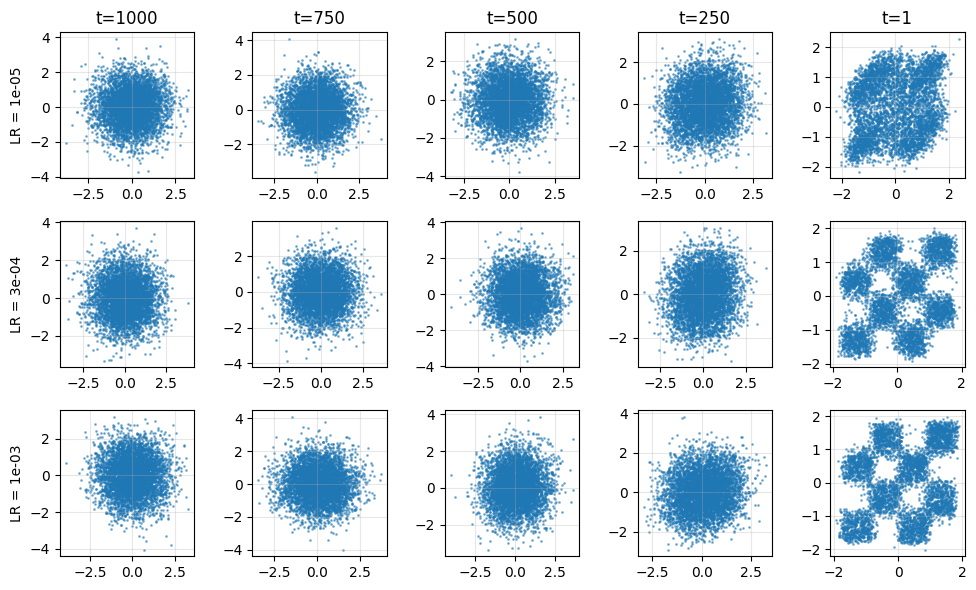

In [36]:
# LEARNING RATE ABLATION (Constant lr, no scheduler)

lr_results = []
lr_values = [1e-5, 3e-4, 1e-3]

for lr in lr_values:
    config = copy.deepcopy(baseline_config)
    config["lr"] = lr
    config["use_scheduler"] = False

    result = train_and_evaluate_model(config, f"LR = {lr:.0e}")
    lr_results.append(result)

plot_comparison(lr_results)

Starting experiment: Batch Size = 256
Final Loss: 0.2344
Starting experiment: Batch Size = 1024
Final Loss: 0.2214
Starting experiment: Batch Size = 2048
Final Loss: 0.2516


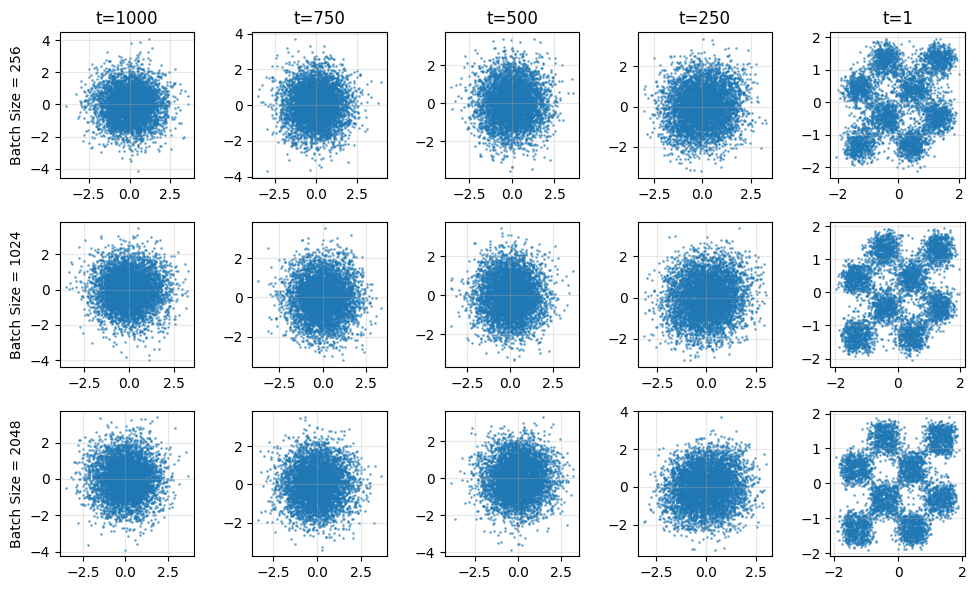

In [37]:
# BATCH SIZE ABLATION

batch_results = []
batch_sizes = [256, 1024, 2048]

for batch_size in batch_sizes:
    config = copy.deepcopy(baseline_config)
    config["BATCH_SIZE"] = batch_size

    result = train_and_evaluate_model(config, f"Batch Size = {batch_size}")
    batch_results.append(result)

plot_comparison(batch_results)

Starting experiment: Number of Timesteps = 100
Final Loss: 0.7092
Starting experiment: Number of Timesteps = 500
Final Loss: 0.3679
Starting experiment: Number of Timesteps = 1000
Final Loss: 0.2756


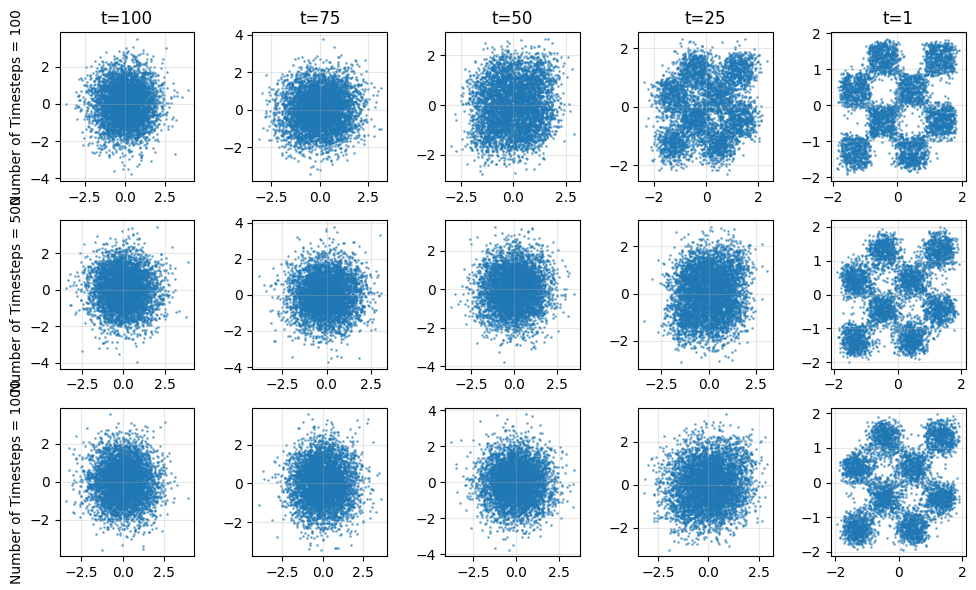

In [35]:
# NUMBER OF TIMESTEPS ABLATION

timestep_results = []
timesteps = [100, 500, 1000]

for T in timesteps:
    config = copy.deepcopy(baseline_config)
    config["num_diffusion_timesteps"] = T

    result = train_and_evaluate_model(config, f"Number of Timesteps = {T}")
    timestep_results.append(result)

plot_comparison(timestep_results)

Starting experiment: Steps = 10k
Final Loss: 0.2734
Starting experiment: Steps = 35k
Final Loss: 0.2581
Starting experiment: Steps = 50k
Final Loss: 0.2508


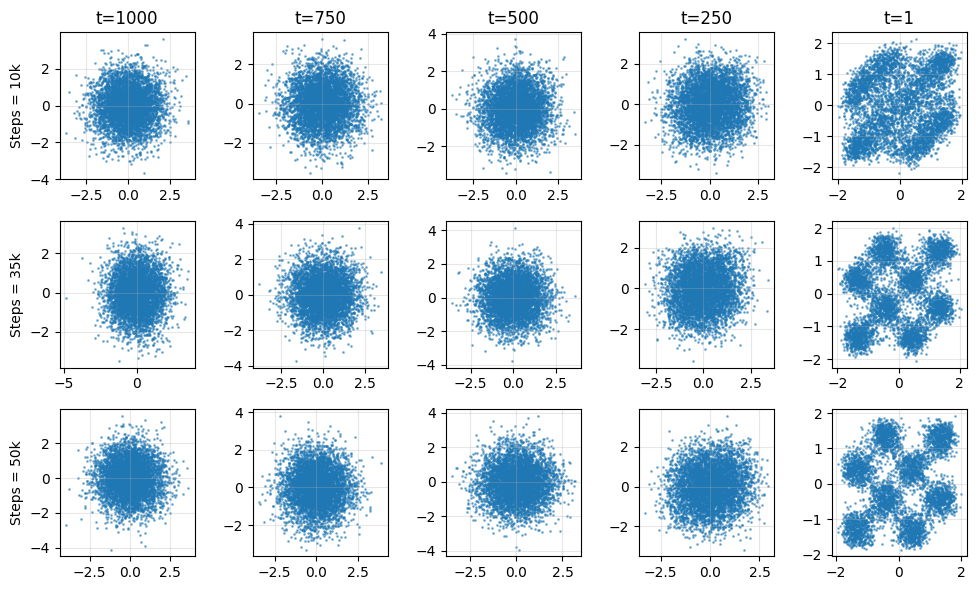

In [38]:
# NUMBER OF TRAINING STEPS ABLATION

steps_results = []
training_steps_list = [10000, 35000, 50000]

for steps in training_steps_list:
    config = copy.deepcopy(baseline_config)
    config["training_steps"] = steps

    result = train_and_evaluate_model(config, f"Steps = {steps // 1000}k")
    steps_results.append(result)

plot_comparison(steps_results)

>**${\large\textbf{\green{Answer:}}}$ Regarding the ablation experiments on the learning rate without scheduler, we evaluated constant learning rates of 1e-5, 3e-4 and 1e-3. With a small learning rate of 1e-5, the model struggled to converge, resulting in poor sample quality and underfitting. The values 3e-4 and 1e-3 led to better convergence and better sample quality, especially with 1e-3, which produced the most realistic samples.**
>
>**For the batch size experiments, sizes 256, 1024 and 2048 were tested. A batch size of 256 resulted in noisy gradients and unstable training, while 1024 provided a good balance between stability and computational efficiency. The largest batch size of 2048 yielded the best results, with smoother training dynamics and higher quality samples, although it required more memory and training time.**
>
>**We also experimented with the number of timesteps, testing 100, 500, and 1000 timesteps. With only 100 timesteps, the model already archieved great results, even better than with 500 and 1000 timesteps despite the fact that the corresponding loss was way higher. This clearly shows that our loss, the noise-prediction MSE, is not a direct sample quality metric and thus that we should not only rely on it to evaluate our model.**
>
>**Finally, we evaluated the impact of the total number of training steps with values 10k, 35k and 50k. The model trained for 10k steps showed clear underfitting, with low-quality samples and high loss values. Training for 35k steps significantly improved sample quality while 50k achieved even better results, but a loss value slightly lower than with 35k steps, showing again the limitation of our loss as a sample quality metric.**

#### Generation/Sampling

**Q.27  Generate samples and plot them at different timestep of the chain. Check how real & synthetic distribution overlap, compare the densities**

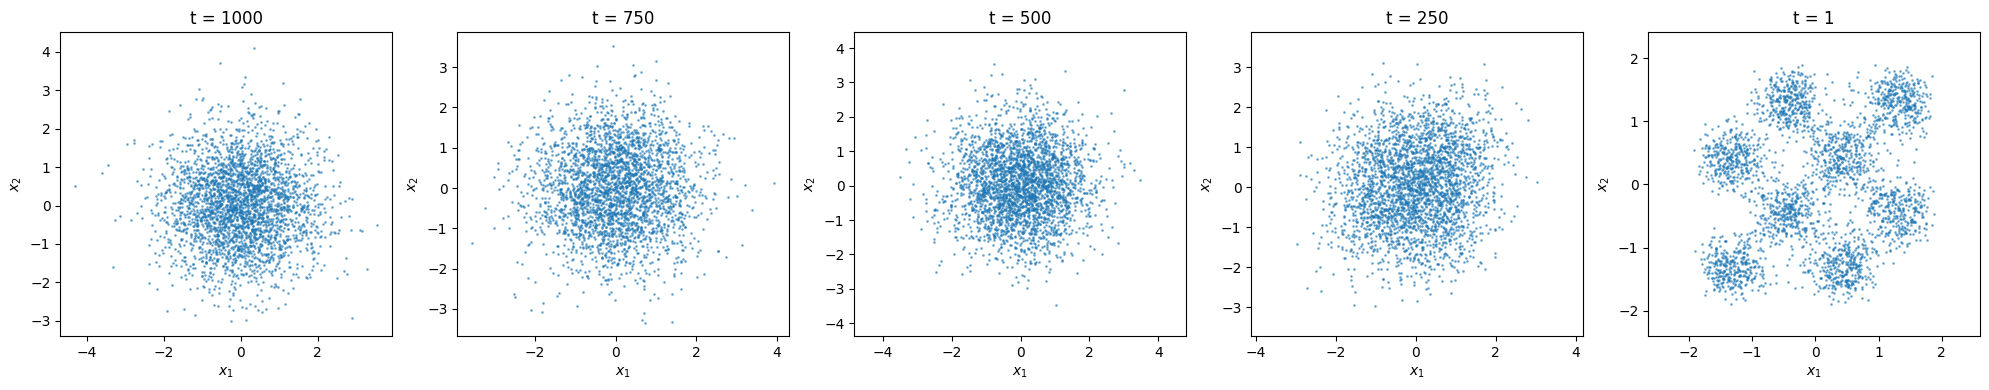

In [22]:
timesteps_to_plot = [
    model._process.tmax,  # pure noise
    int(model._process.tmax * 0.25),
    int(model._process.tmax * 0.5),
    int(model._process.tmax * 0.75),
    model._process.tmin,  # final samples
]

snapshots = sample_with_snapshots(
    model, sample_size=3000, timesteps_to_save=timesteps_to_plot
)

num_plots = len(snapshots)
fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))

if num_plots == 1:
    axes = [axes]

for ax, (t, samples) in zip(axes, snapshots.items()):
    ax.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
    ax.set_title(f"t = {t}")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.axis("equal")

plt.tight_layout()
plt.show()


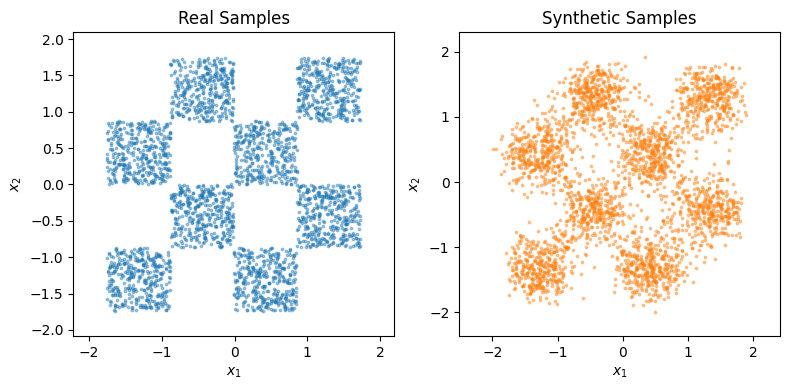

In [23]:
real_samples = generate_batch(3000).cpu()
synthetic_samples = model.sample(x0=real_samples.to(device), sample_size=3000).cpu()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(
    real_samples[:, 0], real_samples[:, 1], s=3, alpha=0.4, color="tab:blue"
)
axes[0].set_title("Real Samples")
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")
axes[0].axis("equal")

axes[1].scatter(
    synthetic_samples[:, 0], synthetic_samples[:, 1], s=3, alpha=0.4, color="tab:orange"
)
axes[1].set_title("Synthetic Samples")
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_2$")
axes[1].axis("equal")

plt.tight_layout()
plt.show()

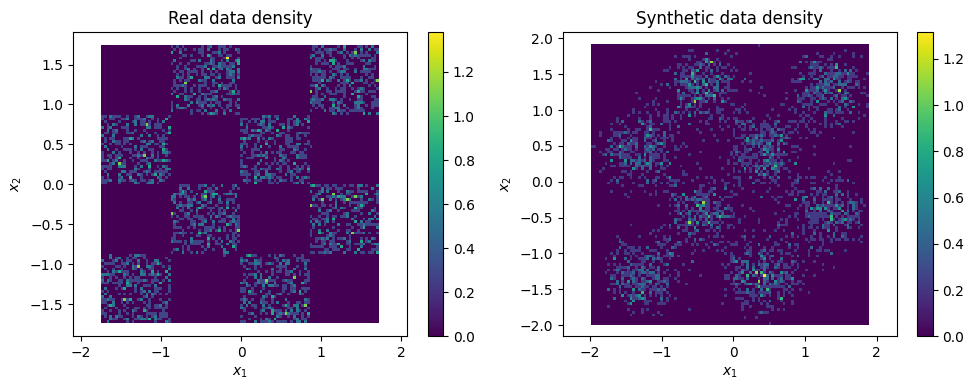

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].hist2d(real_samples[:, 0], real_samples[:, 1], bins=100, density=True)
fig.colorbar(im0[3], ax=axes[0])
axes[0].set_title("Real data density")
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")
axes[0].axis("equal")

im1 = axes[1].hist2d(
    synthetic_samples[:, 0], synthetic_samples[:, 1], bins=100, density=True
)
fig.colorbar(im1[3], ax=axes[1])
axes[1].set_title("Synthetic data density")
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_2$")
axes[1].axis("equal")

plt.tight_layout()
plt.show()

---
## Conclusion

**Q.28: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs, Flow Matching and Denoising Models ?**

>**${\large\textbf{\green{Answer:}}}$ Let's compare the advantages and shortcomings of GANs, VAEs, Flow Matching, and Denoising Models.**
>
>**The advantages of GANs include their ability to generate high-quality and realistic samples, as well as their flexibility in modeling complex data distributions without requiring explicit density estimation. However, GANs can be difficult to train due to issues like mode collapse and instability during training. Mode collapse especially occurs when the generator produces a limited variety of samples, failing to capture the diversity of the real data distribution. A discriminator that becomes too powerful can also lead to vanishing gradients for the generator, making it impossible for the generator to receive meaningful feedback and thus learn effectively.**
>
>**VAEs are known for their ability to learn meaningful latent representations of data, while preserving a stable training process due to their probabilistic framework, which optimizes a variational lower bound on the data likelihood. However, VAEs often produce blurrier samples compared to other generative models, as optimizing the likelihood can lead to averaging effects, trading off stability for sample quality and sharpness.** 
>
>**Flow Matching models aim to model complex data distributions by learning a series of invertible transformations. This allows for exact likelihood computation and efficient sampling. The sampling and inference processes are typically fast due to this invertibility. However, this necessity for invertibility can limit the expressiveness of the model by imposing constraints on the architecture of the neural networks and thus limiting the expressiveness and flexibility of the model. Additionally, training flow-based models can be computationally intensive, especially when facing high-dimensional or complex data.**
>
>**Denoising Models generate data by learning to reverse a gradual noising process, turning noise into structured generated samples. One of their key advantages is their training stability, as they only rely on a simple mean squared error loss. They are also highly effective at capturing complex data distributions and typically do not suffer from mode collapse. However, such diffusion models are computationally expensive at inference time, since generating a single sample requires multiple steps of denoising.**
>
>**In summary, each of these generative models presents a trade-off between sample quality, training stability, computational efficiency, and model expressiveness. The choice of generative model therefore depends on the specific requirements and constraints of each application.**